In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
#Imports all necessary packages for training

In [4]:
#This next line calls the Compose method of the transforms class
#The transforms class contains methods for transforming images and numpy arrays
#The Compose method compounds transformations.
#You add a tuple/list of transformation objects and it composes a new transformation object of the list of transforms

# The image is transformed like so 
# Image ---> ToTensor (normalized from [0,1], ---> Normalize (now normalizes from [-1,1])
# Here is a discussion on the topic https://discuss.pytorch.org/t/understanding-transform-normalize/21730/4

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



In [5]:
#This line loads the cifar10 dataset into the given 'root' directory, sets the data set's flag to indicate it
#is a training dataset (not a test) and then downloads and adds a transformation to the set.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transformation)

Files already downloaded and verified


In [6]:
#trainloader is now a dataloader object which uses a
#batch size of 4 (it updates the models parameters every 4 images)
# num workers determines how many batches are prepared or loaded before hand
# if num_workers is 0 this means data will be loaded in the main process and not in parallel. 
# Shuffle randomly selects pictures
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=5)

In [7]:
#This is the same as the last two cell. The only difference is that this is the test data or the 
# data which will verify the accuracy of our trained model.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=5)


Files already downloaded and verified


In [8]:
#Defines a tuple of classes to be classified from the data set
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

  dog horse truck  bird


In [10]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



In [13]:
device = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(device)
if device_name[0:11] == 'GeForce RTX':
    net = net.cuda().half()
elif torch.cuda.is_available():
    net = net.cuda()
else:
    torch.device("cpu")
    net = Net()
    

In [19]:
import torch.optim as optim
# Declare loss function as cross entropy
criterion = nn.CrossEntropyLoss().half()
# Optimizer is delcared as Stochastic gradient descent which modififies the parameters
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        #Optional step which converts the inputs to cuda tensors at each step
        inputs, labels = inputs.to(device = device, dtype = torch.half), labels.to(device = device, dtype = torch.half)        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Expected object of scalar type Long but got scalar type Half for argument #2 'target'

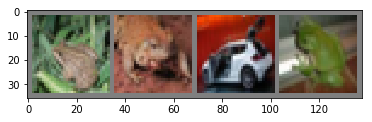

GroundTruth:   frog  frog   car  frog


In [28]:
dataiter = iter(testloader)
dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
outputs = net(images)

In [18]:
outputs

tensor([[-1.0976, -2.2967,  0.9392,  2.8876, -0.5978,  1.9339,  1.1233, -0.9141,
         -1.1782, -1.8220],
        [ 2.3320,  4.8465, -1.9602, -3.3302, -3.5795, -3.8951, -3.4327, -3.7596,
          5.6423,  3.0020],
        [ 1.1275,  2.1957, -0.4658, -1.5253, -1.4480, -2.1824, -1.6195, -2.2438,
          2.4846,  0.9475],
        [ 2.5358,  0.5930,  0.4925, -1.5977, -0.4717, -2.4014, -1.6787, -2.5349,
          3.0853, -0.1565]], grad_fn=<AddmmBackward>)

In [33]:
_, predicted = torch.max(outputs,1)

In [34]:
_
predicted


tensor([4, 6, 1, 4])

In [35]:
print('Predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  deer  frog   car  deer


In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 76 %
Accuracy of  bird : 39 %
Accuracy of   cat : 49 %
Accuracy of  deer : 51 %
Accuracy of   dog : 35 %
Accuracy of  frog : 58 %
Accuracy of horse : 61 %
Accuracy of  ship : 74 %
Accuracy of truck : 54 %
